<h1> <center> GaussianFace

**Table of Contents**

[Part 1: Theory](#Part-1:-Theory)
  - [1.1. Introduction](#1.1.-Introduction)
  - [1.2. Probability & Statistical Background](#1.2.-Probability-&-Statistical-Background)
  - [1.3. GMM Algorithm](#1.3.-GMM-Algorithm)

[Part 2: Scikit-Learn GMM Class](#Part-2:-Scikit-Learn-GMM-Class)
  - [2.1. Overview](#2.1.-Overview)
  - [2.2. Anomaly Detection with GMM](#2.2.-Anomaly-Detection-with-GMM)
  - [2.3. Selecting the Number of Clusters](#2.3.-Selecting-the-Number-of-Clusters)

[Part 3: Human Face Image Generation with Gaussian Mixtures](#Part-3:-Human-Face-Image-Generation-with-Gaussian-Mixtures)
  - [3.1.1. Introducing LFW Dataset](#3.1.1.-Introducing-LFW-Dataset)
  - [3.1.2. Overcoming Computational Complexity: Reducing Feature Space Dimensionality](#3.1.2.-Overcoming-Computational-Complexity:-Reducing-Feature-Space-Dimensionality)
  - [3.1.3. Overcoming Computational Complexity: Selective Training SubSet](#3.1.3.-Overcoming-Computational-Complexity:-Selective-Training-SubSet)
  - [3.1.4. Fitting GMM and Generating Some Faces!](#3.1.4.-Fitting-GMM-and-Generating-Some-Faces!)
  - [3.1.5. Improving Generated Image Quality: Fitting GMM on a Subset of "Similar Faces"](#3.1.5.-Improving-Generated-Image-Quality:-Fitting-GMM-on-a-Subset-of-"Similar-Faces")



## Part 1: Theory

#### 1.1. Introduction

A **Gaussian Mixture Model (GMM)** is a statistical model that assumes the data is generated from a mixture of several Gaussian distributions, each with unknown parameters.

GMM is a powerful clustering algorithm. It assumes that each cluster corresponds to a Gaussian distribution, characterized by the following parameters:

- Mean vector: $\mu_k$
- Covariance matrix: $\Sigma_k$
- Mixture weight: $\pi_k$, which represents the probability that a randomly chosen instance belongs to the $k$-th cluster.

Unlike K-Means, which tends to form spherical clusters, GMM allows for elliptical cluster shapes with different orientations, shapes, and variances.


#### 1.2. Probability and Statistical Background

- **Probability Density Function (PDF)**: For continuous random variables, the PDF describes the likelihood of the variable taking a particular value. For a random variable $X$, the PDF $f(x)$ satisfies:

  $$
  \int_{-\infty}^{\infty} f(x)\,dx = 1
  $$

- **Cumulative Distribution Function (CDF)**: The probability that $X \leq x$, given by:

  $$
  F(x) = P(X \leq x) = \int_{-\infty}^{x} f(t)\,dt
  $$

---

**Likelihood**

- **Likelihood** measures how plausible a model is given the data you have observed. In other words, how well the probabilistic model with parameter $\theta$ fits the data, or how well the model explains the data.

- **Probability**, on the other hand, predicts future outcomes given a model.

- For independent and identically distributed (i.i.d.) data points $x_1, x_2, \ldots, x_n$, the likelihood is:

  $$
  L(\theta \mid x_1, \ldots, x_n) = \prod_{i=1}^n f(x_i \mid \theta)
  $$

  where $f(x_i \mid \theta)$ is the probability density of observing $x_i$ under parameters $\theta$.

- Since multiplying can cause numerical instability (due to very small values), we define the log-likelihood function, which is easier to maximize:

  $$
  \ell(\theta) = \log L(\theta) = \sum_{i=1}^n \log f(x_i \mid \theta)
  $$

---

**Likelihood Estimation**

- **Likelihood estimation** (or **Maximum Likelihood Estimation**) is the process of finding model parameters $\theta$ that make the observed data most likely, or make the model best fit the data.  
- In other words, we tweak $\theta$ to achieve the best $L(\theta)$ or $\ell(\theta)$.

---

**Multivariate Gaussian Distribution**

- A **univariate Gaussian** has a probability density function (PDF) of:

  $$
  f(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
  $$

  where $\mu$ is the mean and $\sigma^2$ is the variance.

- A **multivariate Gaussian** (for a $d$-dimensional vector $x$) has the PDF:

  $$
  f(x \mid \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) \right)
  $$

  where:
  - $\mu$: $d$-dimensional mean vector  
  - $\Sigma$: $d \times d$ covariance matrix (symmetric and positive definite)  
  - $|\Sigma|$: Determinant of the covariance matrix  
  - $\Sigma^{-1}$: Inverse of the covariance matrix


#### 1.3. GMM Algorithm

A **Gaussian Mixture Model (GMM)** assumes that the data is generated from a mixture of $K$ Gaussian distributions. Each data point $x_i$ is associated with a latent variable $z_i$, which indicates the component (Gaussian) it belongs to.

---

**Model Definition**
- **Components**:
  - $K$ Gaussian distributions, each with:
    - Mean vector: $\mu_k$
    - Covariance matrix: $\Sigma_k$
    - Mixing coefficient: $\pi_k$, representing the weight (or probability) of the $k$-th component
- **Constraints**:
  - The mixing coefficients must sum to 1:
    $$\sum_{k=1}^{K} \pi_k = 1$$
  - The mixing coefficients must be in the range $[0, 1]$:
    $$0 \leq \pi_k \leq 1$$
  - The PDF of a GMM for a data point $x$ is:
    $$p(x \mid \theta) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x \mid \mu_k, \Sigma_k)$$
    where $\mathcal{N}(x \mid \mu_k, \Sigma_k)$ is the multivariate Gaussian PDF, and $\theta = \{ \pi_k, \mu_k, \Sigma_k \}_{k=1}^K$ are the model parameters.

**Latent Variable Representation**
- Each data point $x_i$ is associated with a latent variable $z_i$, where:
  $$z_i = k$$
  means that $x_i$ was generated by the $k$-th Gaussian.
- $z_i$ follows a categorical distribution:
  $$p(z_i = k) = \pi_k$$
- The conditional distribution of $x_i$ given $z_i = k$ is:
  $$p(x_i \mid z_i = k) = \mathcal{N}(x_i \mid \mu_k, \Sigma_k)$$

---

**Formulations and Derivations**
**Likelihood of the Data**:
Given $n$ i.i.d. data points $x_1, x_2, \ldots, x_n$, the likelihood is:
$$L(\theta) = \prod_{i=1}^{n} p(x_i \mid \theta) = \prod_{i=1}^{n} \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k)$$

Where:
- $\theta = \{ \pi_k, \mu_k, \Sigma_k \}_{k=1}^K$ represents the parameters of the Gaussian Mixture Model (GMM)
- $\mathcal{N}(x_i \mid \mu_k, \Sigma_k)$ is the multivariate Gaussian probability density function (PDF) for the $k$-th component

The **log-likelihood** is:
$$\ell(\theta) = \sum_{i=1}^{n} \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \right)$$

To maximize the log-likelihood, we take the **derivatives** of $\ell(\theta)$ with respect to the parameters $\pi_k$, $\mu_k$, and $\Sigma_k$, and set them equal to zero. However, solving these derivatives analytically is complex due to the sum inside the logarithm. Thus, we use an **iterative approach** known as the **Expectation-Maximization (EM)** algorithm. The EM algorithm iteratively updates the parameters to maximize the likelihood, simplifying the optimization process and gradually satisfying the gradient equations.

---

**EM Algorithm**
The EM algorithm is used to fit a GMM because directly maximizing the likelihood is tricky due to the latent variables (we don't know which Gaussian each data point comes from). Imagine you have a dataset of 2D points that seem to form two clusters (e.g., heights and weights of people from two groups). You believe these points come from a mixture of two Gaussians, but you don't know:
- Which points belong to which Gaussian
- The parameters $\pi_k, \mu_k, \Sigma_k$ of each Gaussian

If you knew which points belonged to each Gaussian, you could easily compute the mean, covariance, and weight of each cluster. But since you don't, the EM algorithm alternates between guessing the assignments and updating the parameters.

**Step 0: Initialization**
Start with a guess for the parameters $\theta$. For example:
- Pick two random points as initial means $\mu_1, \mu_2$
- Set initial covariances $\Sigma_1, \Sigma_2$ as identity matrices
- Set equal weights, e.g., $\pi_1 = \pi_2 = 0.5$

This is like drawing two rough ellipses (Gaussians) on a scatterplot of your data.

**Step 1: Expectation (E-Step) - "Soft Assignment"**
For each data point, calculate the probability that it belongs to each Gaussian. This is called the responsibility $\gamma_{ik}$. Intuitively, if a point is close to the mean of Gaussian 1, it's more likely to belong to Gaussian 1, but it might still have a small chance of belonging to Gaussian 2.

Instead of hard assignments (like in K-means), EM uses soft assignments (probabilities). Example: A point might have a 70% chance of belonging to Gaussian 1 ($\gamma_{i1} = 0.7$) and a 30% chance for Gaussian 2 ($\gamma_{i2} = 0.3$).

The formula for responsibility is:
$$\gamma_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}$$

This weighs the likelihood of the point under each Gaussian by the mixing coefficient $\pi_k$.

**Step 2: Maximization (M-Step) - "Update Parameters"**
Use the responsibilities to update the parameters:
- **Mixing coefficients** $\pi_k$: The weight of each Gaussian is the average responsibility across all points:
  $$\pi_k = \frac{1}{n} \sum_{i=1}^{n} \gamma_{ik}$$
  If many points have high responsibility for Gaussian 1, its weight $\pi_1$ increases.
- **Means** $\mu_k$: Compute a weighted average of the points, where each point's contribution is weighted by its responsibility:
  $$\mu_k = \frac{\sum_{i=1}^{n} \gamma_{ik} x_i}{\sum_{i=1}^{n} \gamma_{ik}}$$
  Points with higher $\gamma_{ik}$ pull the mean more strongly.
- **Covariances** $\Sigma_k$: Compute a weighted covariance matrix:
  $$\Sigma_k = \frac{\sum_{i=1}^{n} \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^{n} \gamma_{ik}}$$
  This adjusts the shape and spread of the Gaussian based on the points assigned to it.

Intuitively, this step refines the ellipses (Gaussians) to better fit the points, based on how much each point "belongs" to each Gaussian.

**Step 3: Iterate**
Repeat the E-Step and M-Step until the parameters stabilize (i.e., the log-likelihood stops increasing significantly). Each iteration improves the fit: the Gaussians move closer to the true clusters, and the responsibilities become more certain (e.g., points strongly belong to one Gaussian).

## Part 2: Scikit-Learn GMM Class

#### 2.1. Overview

In this section, we will use **Sklearn's `GMM` class** to fit the Iris dataset and visualize the clusters in the dimension-reduced dataset.

**Important Notes**

- Just like **KMeans**, we have to define the number of clusters (components). This is one drawback of GMM compared to algorithms such as **DBSCAN**.
- Again, just like **KMeans**, the algorithm does **not guarantee** convergence to the global optimum. Thus, we initialize **EM** multiple times and pick the best result.  
  **_BEWARE:_** The default number of initializations (`n_init`) in the `GMM` class is **1**.

In [5]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_iris, fetch_lfw_people
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from skimage.transform import resize

import numpy as np
from joblib import dump, load
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

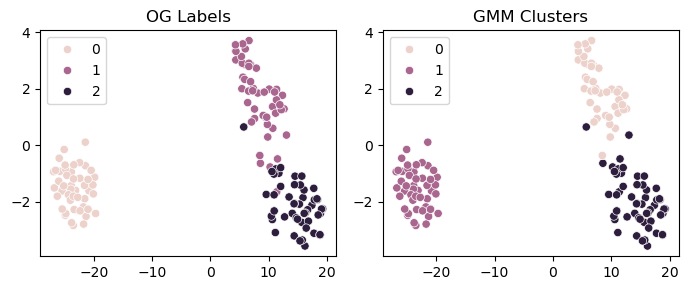

In [24]:
X,y = load_iris(return_X_y=True)

gmm = GaussianMixture(n_components=3,random_state=42, n_init=10).fit(X)

X_tsne = TSNE(n_components=2,n_jobs=-1,random_state=42).fit_transform(X)
fig,ax=plt.subplots(1,2,figsize=(7,3))
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],ax=ax[0],hue=y)
ax[0].set_title("OG Labels")
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],ax=ax[1],hue=gmm.predict(X))
ax[1].set_title("GMM Clusters")
plt.tight_layout()
plt.show()

In [15]:
# cluster weights
gmm.weights_

array([0.36539575, 0.33333333, 0.30127092])

In [16]:
# each guassian mean
gmm.means_

array([[6.54639415, 2.94946365, 5.48364578, 1.98726565],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [5.9170732 , 2.77804839, 4.20540364, 1.29848217]])

In [17]:
# cov matrices
gmm.covariances_

array([[[0.38744093, 0.09223276, 0.30244302, 0.06087397],
        [0.09223276, 0.11040914, 0.08385112, 0.05574334],
        [0.30244302, 0.08385112, 0.32589574, 0.07276776],
        [0.06087397, 0.05574334, 0.07276776, 0.08484505]],

       [[0.121765  , 0.097232  , 0.016028  , 0.010124  ],
        [0.097232  , 0.140817  , 0.011464  , 0.009112  ],
        [0.016028  , 0.011464  , 0.029557  , 0.005948  ],
        [0.010124  , 0.009112  , 0.005948  , 0.010885  ]],

       [[0.2755171 , 0.09662295, 0.18547072, 0.05478901],
        [0.09662295, 0.09255152, 0.09103431, 0.04299899],
        [0.18547072, 0.09103431, 0.20235849, 0.06171383],
        [0.05478901, 0.04299899, 0.06171383, 0.03233775]]])

In [18]:
# let's check if algorithm converged or not
gmm.converged_

True

In [21]:
# and how many EM iterations took to converge?
gmm.n_iter_

17

**Soft Clustering & Hard Clustering**

Now that the model is fitted to the data and we have (hopefully) found the optimal parameters, we can cluster the data points. Not only can we assign each instance to a cluster (**hard clustering**), but we can also estimate the probability that each instance belongs to each cluster (**soft clustering**).

In [32]:
# hard clustering

gmm.predict(X[:4])

array([1, 1, 1, 1], dtype=int64)

In [33]:
# soft clustering
gmm.predict_proba(X[:4])

array([[9.06516804e-44, 1.00000000e+00, 6.39829159e-35],
       [8.53836828e-31, 1.00000000e+00, 2.59954184e-28],
       [9.37295905e-36, 1.00000000e+00, 4.21198692e-30],
       [1.46701195e-31, 1.00000000e+00, 2.71194113e-26]])

In [35]:
# GMM is a generative models, it can gernarate instances based on learned parameters:

gmm.sample(2)

(array([[4.95469961, 3.03014455, 1.61074184, 0.25014837],
        [4.54932764, 2.79918888, 1.5112294 , 0.2811497 ]]),
 array([1, 1]))

**Reducing Model Complexity**

When there are many dimensions, many clusters, or few instances, the algorithm can struggle to converge to an optimal solution. We can constrain the model by limiting the shapes and orientations that clusters can take. This is controlled by the covariance matrix. The `covariance_type` hyperparameter is responsible for this and accepts the following values:

- **spherical**: All clusters must be spherical, but they can have different diameters (i.e., different variances).
- **diag**: Clusters can take on any ellipsoidal shape of any size, but the ellipsoid’s axes must be parallel to the coordinate axes (i.e., the covariance matrices must be diagonal).
- **tied**: All clusters must have the same ellipsoidal shape, size, and orientation (i.e., all clusters share the same covariance matrix).
- **full**: Each cluster can take on any shape, size, and orientation.

In [37]:
gmm.covariance_type

'full'

#### 2.2. Anomaly Detection with GMM

The `score_samples(x_i)` method in the GMM class returns the **log likelihood** (density) of points around the instance `x_i`. This can be used as a measure to detect anomalies, as anomalies typically occur in regions with the **lowest densities**.

To detect anomalies, we need to set a **threshold** that indicates the proportion of anomalies (usually based on prior knowledge). By adjusting this threshold, we can control the detection of anomalies and fine-tune the model, potentially using metrics like **false positives** and **false negatives** to evaluate and improve the model's performance.


Count of Outliers detected: 3


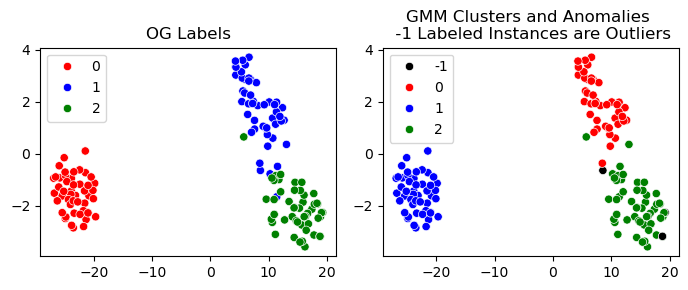

In [75]:
densities = gmm.score_samples(X)
density_threshold = np.percentile(densities,2)
y_out = gmm.predict(X)
y_out[densities<density_threshold] = -1

palette = {0: 'red', 1: 'blue', 2: 'green', -1: 'black'}
print(f"Count of Outliers detected: {np.sum(densities<density_threshold)}")
fig,ax=plt.subplots(1,2,figsize=(7,3))
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],ax=ax[0],hue=y,palette=palette)
ax[0].set_title("OG Labels")
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],ax=ax[1],hue=y_out,palette=palette)
ax[1].set_title("GMM Clusters and Anomalies \n -1 Labeled Instances are Outliers")
plt.tight_layout()
plt.show()

#### 2.3. Selecting the Number of Clusters

For **KMeans**, we can use the **Silhouette Score** to evaluate different clustering results and select the optimal number of clusters. However, the Silhouette Score inherently favors clusters with a spherical shape, which aligns with the assumptions KMeans makes when partitioning data.

On the other hand, **GMMs** can model ellipsoidal clusters, making the Silhouette Score less suitable for evaluating GMM-based clustering. Instead, the `GMM` class provides two metrics that minimize a theoretical information criterion: the **Bayesian Information Criterion (BIC)** and the **Akaike Information Criterion (AIC)**.

The formulas for these are:

- **BIC**: $ \log(m) \cdot p - 2 \cdot \log(\mathcal{L}) $
- **AIC**: $ 2 \cdot p - 2 \cdot \log(\mathcal{L}) $

Where:
- $m$ is the number of instances,
- $p$ is the number of parameters learned by the model,
- $\mathcal{L}$ is the maximized value of the likelihood function of the model.

Both BIC and AIC aim to find the clustering configuration that maximizes the likelihood of the data while penalizing model complexity (i.e., the number of parameters). This effectively influences the number of clusters, encouraging simpler models with fewer clusters.

When BIC and AIC give different results, BIC typically favors simpler models (fewer parameters), while AIC tends to choose models that better fit the data. This difference is more noticeable in larger datasets, where **AIC may be preferable** if maximizing model fit is prioritized over simplicity.


In [91]:
print(f"Current GMM AIC Score: {gmm.aic(X).round(3)} and BIC Score: {gmm.bic(X).round(3)}")

Current GMM AIC Score: 448.391 and BIC Score: 580.859


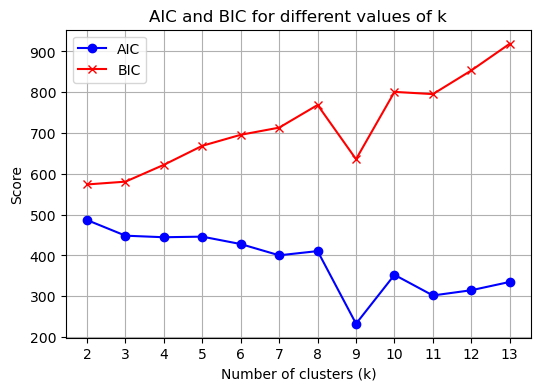

In [90]:
def gmm_k_selection(k_range, X):
    aic_list, bic_list = [], []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10).fit(X)
        aic_list.append(gmm.aic(X))
        bic_list.append(gmm.bic(X))
    plt.figure(figsize=(6, 4))
    plt.plot(k_range, aic_list, label='AIC', color='blue', marker='o')
    plt.plot(k_range, bic_list, label='BIC', color='red', marker='x')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Score')
    plt.title('AIC and BIC for different values of k')
    plt.xticks(k_range)
    plt.legend()
    plt.grid(True)
    plt.show()

gmm_k_selection(range(2,14), X)

## Part 3: Human Face Image Generation with Gaussian Mixtures

#### 3.1.1. Introducing LFW Dataset

If you recall, in the last section I mentioned that a GMM is a generative model, meaning it can synthesize samples based on learned parameters. Now, what if we fit a GMM to an image dataset? Can it generate images? To be honest, that’s a fantastic idea, and I’m super excited about it because this is my first generative model (hopefully the first of many to come). Although Image data might not satisfy GMM assumption of *Mixture of Gaussians*, we will try!

So, I will apply this method to LFW Image Dataset (Labeled Faces in the Wild). Can we push AI to the next level and generate human faces that are almost indistinguishable from real ones? Let’s try and see!

---
**LFW Dataset**

The Labeled Faces in the Wild (LFW) dataset is a benchmark collection of over 13,000 facial images of 5,749 individuals, gathered from news articles. Each image is labeled with the person's name, and 1,680 of the subjects have two or more distinct photos. The dataset is primarily used for studying face recognition in unconstrained environments. Images vary in pose, lighting, and expression, reflecting real-world conditions. LFW supports both verification (same/not same person) and identification tasks.

---
**GMM Computation Complexity**

When the `covariance_type` is set to "tied" or "full" (allowing clusters to take any shape with maximum degrees of freedom), the GMM has a computational complexity of $O(kmn^2 + kn^3)$, where n is number of dimensions. This becomes problematic for high-dimensional data. In the case of the LFW dataset, each image is 62x47 pixels, resulting in an array of 2,914 dimensions.

In the following sections, I will apply some optimizations to make fitting the GMM to this dataset feasible from a time perspective.

In [ ]:
lfw_data = fetch_lfw_people().data

Let’s plot a few LFW images and create an image viewer function to simplify things down the road.

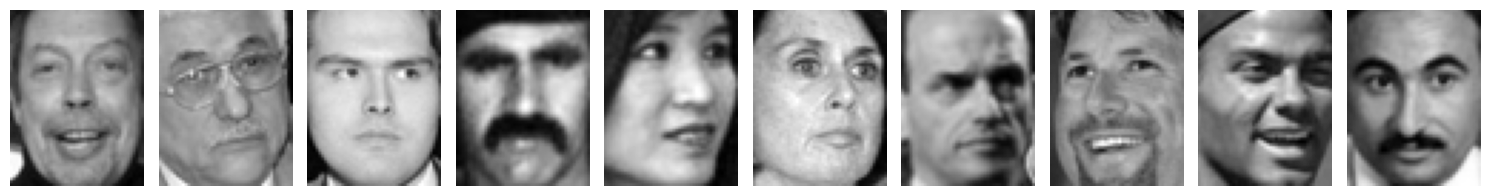

In [15]:
def image_group_viewer(X, size=None, cmap="gray", cntperrow=10):
    """Group image viewer"""
    count = len(X)
    rows = (count // cntperrow) + (count % cntperrow != 0)  
    if size is None:
        sqrt_ = int(np.sqrt(X.shape[1]))
        size = (sqrt_,sqrt_) 
    fig, ax = plt.subplots(rows, cntperrow, figsize=(15, rows * 3))
    ax = ax.flatten()
    for i in range(count):
        ax[i].imshow(X[i].reshape(size), cmap=cmap)
        ax[i].axis("off")
    for j in range(count,len(ax)):
        ax[j].axis("off") 
    plt.tight_layout()
    plt.show()

image_group_viewer(lfw_data[:10],size=(62,47))

#### 3.1.2. Overcoming Computational Complexity: Reducing Feature Space Dimensionality

We can project this high-dimensional data into a lower-dimensional feature space using a linear projection method like Principal Component Analysis (PCA). By setting the variance ratio to 0.99, we can preserve most of the information. While PCA is still a linear method (which may not be ideal for image data), using nonlinear manifold learning techniques would negate the benefit of reduced runtime. So, PCA it is.

In [21]:
pca = PCA(n_components=0.99,random_state=42)
X_pca = pca.fit_transform(lfw_data)
print(f"Counts of PCs: {pca.n_components_}")

Counts of PCs: 635


#### 3.1.3. Overcoming Computational Complexity: Selective Training SubSet

The dataset contains 13,233 images, and training a GMM on the entire set—despite reducing the feature space—can still be pretty computationally expensive. To make this more manageable, I use a simple yet effective trick: I first cluster the entire dataset into the number of clusters corresponding to the desired size of the reduced training subset. Then, I pick the data point closest to each cluster's centroid to act as a representative sample. This way, I can train the GMM on a smaller, but still representative, subset of the full dataset.

For clustering, I use MiniBatchKMeans because it converges faster and gives results that are very close to the standard KMeans algorithm, but with better efficiency.

In [60]:
def kmeans_cluster_representatives(X,n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=42)
    X_digits_dist = kmeans.fit_transform(X)
    rep_imgs_idx = np.argmin(X_digits_dist, axis=0)
    return X[rep_imgs_idx]
    
n_reps = 2500
X_reps = kmeans_cluster_representatives(X_pca,n_reps)

#### 3.1.4. Fitting GMM and Generating Some Faces

As mentioned in the previous section, we can use BIC, AIC, and BayesianGaussianMixture to determine the number of Gaussians. However, for image generation, I trust my own eyes. Therefore, I will fit multiple GMMs with different numbers of Gaussians and inspect the quality of the generated images myself.

Just to remind you: we reduced the dimensionality of the data using PCA, and before plotting each image, we need to bring it back to the original dimensional space.

Number of Components:5


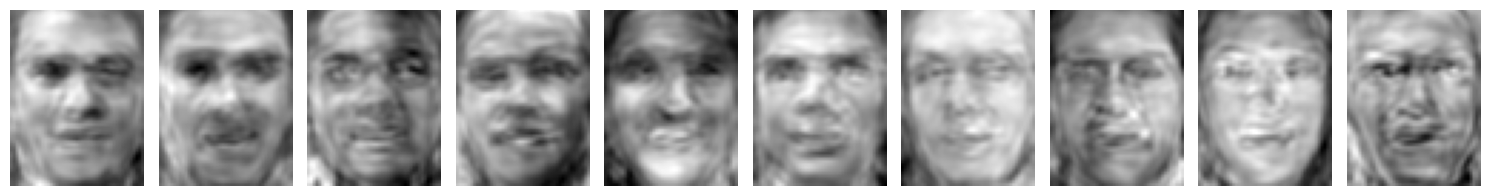

Number of Components:15


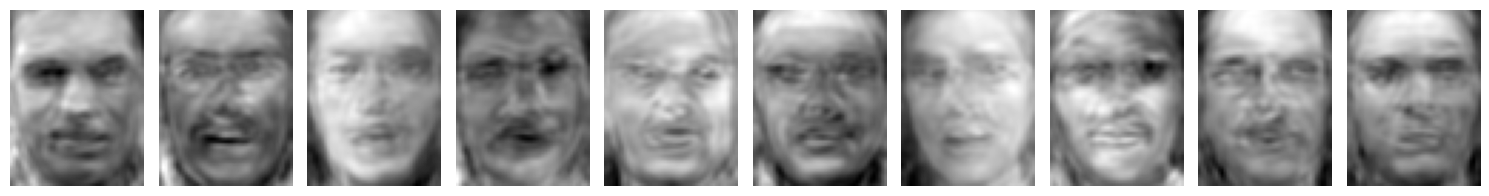

Number of Components:25


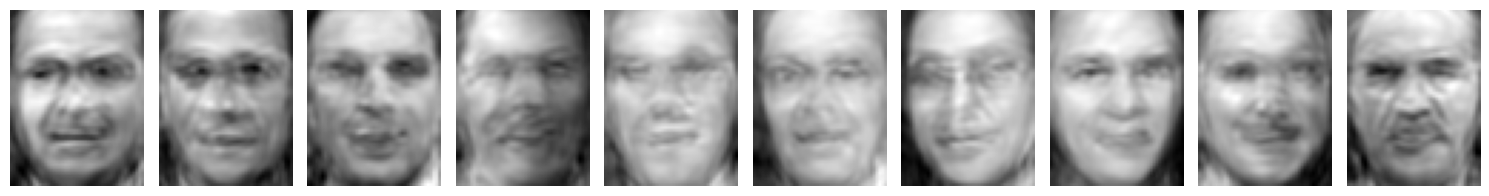

Number of Components:25


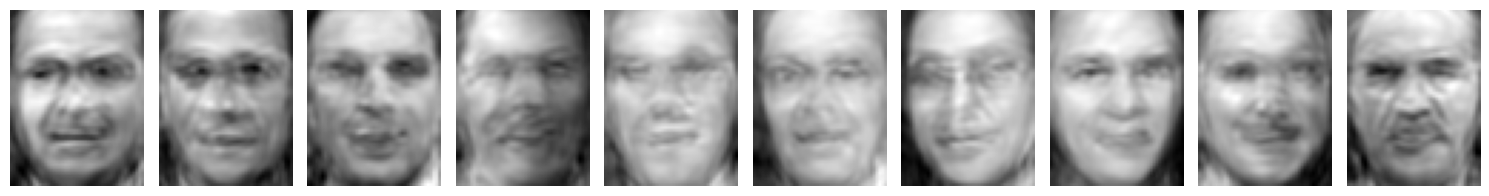

Number of Components:35


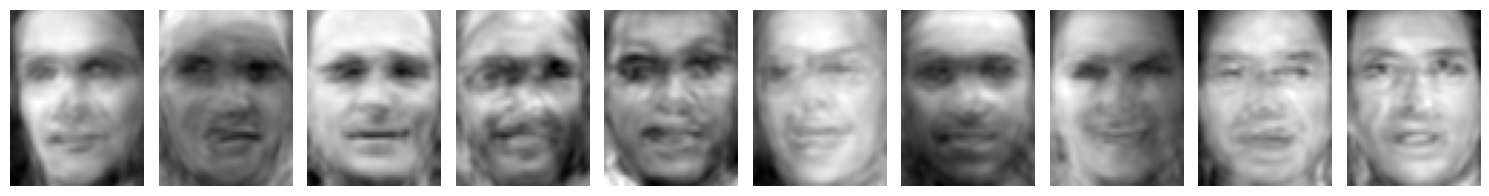

Number of Components:50


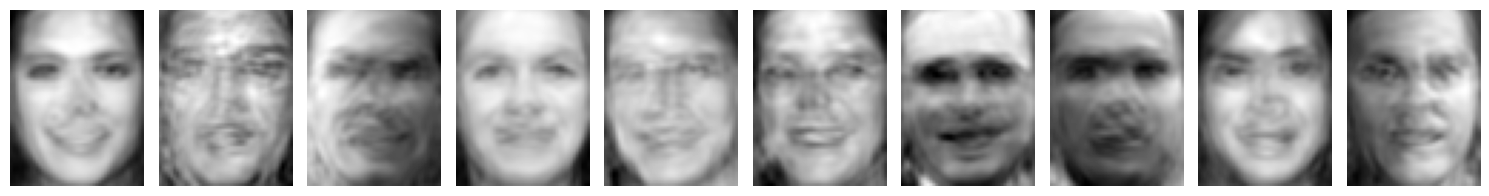

Number of Components:70


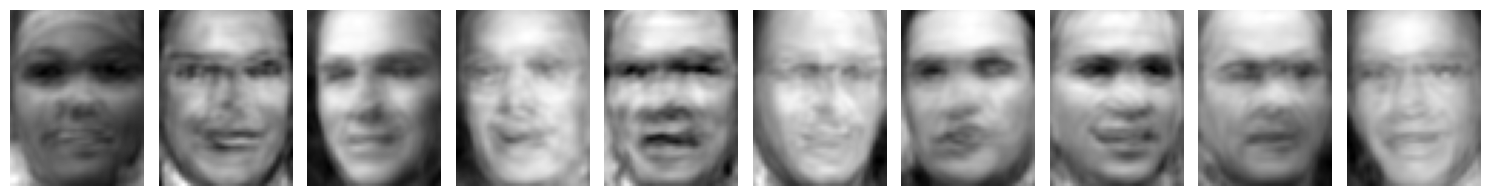

Number of Components:100


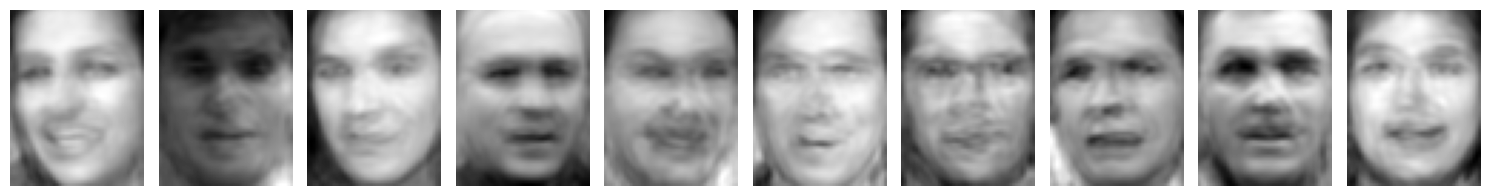

Number of Components:150


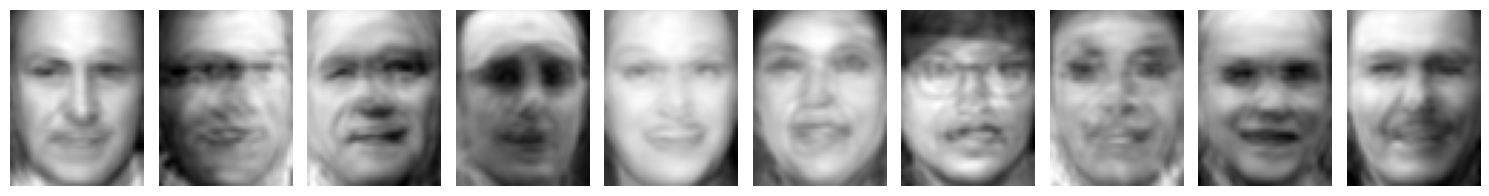

In [14]:
components_list = [5,15,25,25,35,50,70,100,150]
for n_components in components_list:
    gmm = BayesianGaussianMixture(n_components=n_components,random_state=42,n_init=5 ,covariance_type="full").fit(X_reps)
    print(f"Number of Components:{n_components}")
    X_gen,_ = gmm.sample(10)
    X_gen = pca.inverse_transform(X_gen)
    image_group_viewer(X_gen,size=(62,47), cntperrow=10)

Okay, first of all—HOLY CRAP! I generated these faces! *Infinite POWERRRR!*

Second of all, it seems like these images could be straight out of a creepy movie, where at the end, they reveal that the story was based on real events.

Now, let’s analyze the results:

If you focus closely, you’ll notice that as we increase the number of components, the images start looking more human-like. Some even become too human-like! In fact, some of the images with 150 components are almost identical to the training images fed into the GMM. And here’s why: when you increase the number of components, the model has more parameters to fit. This gives it greater flexibility, allowing it to capture finer details from the training images. So, in higher component setups, some images end up being almost identical to the training set. Essentially, it overfits the data.

On the flip side, when the number of components is too low, the GMM tries to fit the entire dataset into just a few clusters (like 5 clusters). This leads to images that feel more unsettling and less human, since the **model is forced to generalize too much**.

All in all, this has been an amazing first experience with image generation! It's super cool to see it come to life. Now, let’s move on and explore some other methods to see if we can create an artificial human face!

#### 3.1.5. Improving Generated Image Quality: Fitting GMM on a Subset of Similar Faces

So far, I’ve trained a GMM on a dimension-reduced subset of data consisting of K-Means cluster representatives. This approach captured the full variety of the dataset in a smaller, representative sample.

Now, let’s explore the opposite approach: fitting a GMM on a group of similar faces. Could this produce more realistic artificial faces?

To select similar images, several methods are available, such as similarity matrices or clustering. Since I want to examine subsets of similar faces, I’ll use K-Means clustering and visualize images from each cluster to assess their similarity.

Additionally, I’ll compute the inertia (mean intra-cluster distances) for each cluster. However, note that lower inertia might reflect similarities in lighting or exposure rather than facial features. Therefore, I’ll rely on visual inspection to confirm the quality of the clusters.

Sorted per-cluster inertia: {4: 37374.723, 11: 44394.01, 2: 46403.39, 3: 47209.83, 5: 51669.336, 8: 57187.445, 10: 58671.938, 0: 60319.52, 9: 61456.523, 7: 63211.957, 6: 68493.75, 1: 71596.28}
CLUSTER ID:0


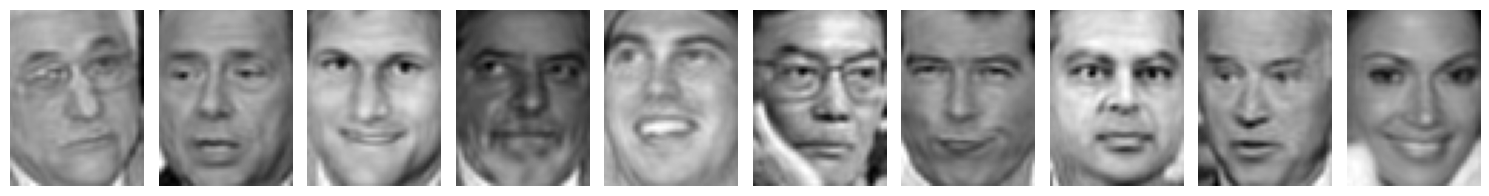

CLUSTER ID:1


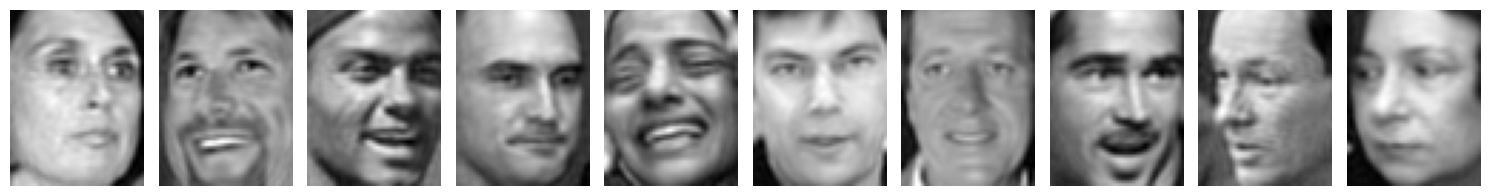

CLUSTER ID:2


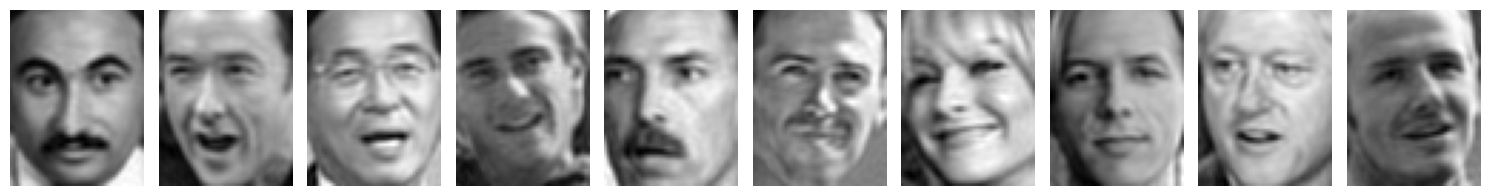

CLUSTER ID:3


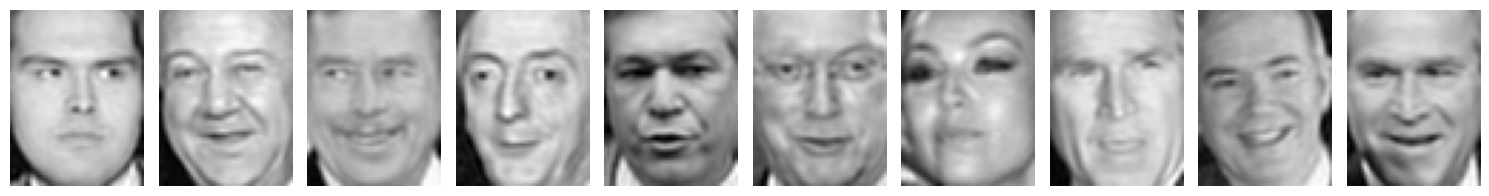

CLUSTER ID:4


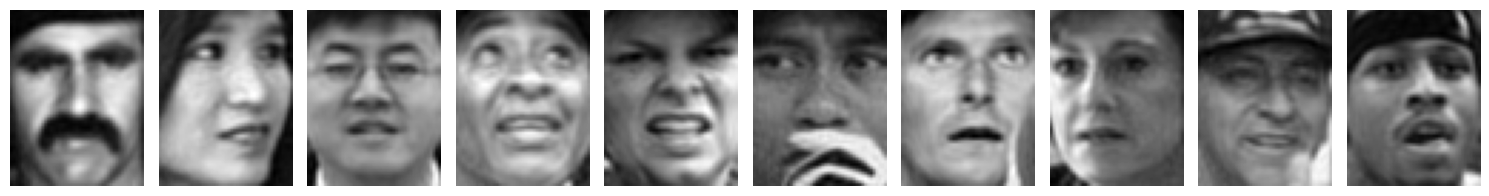

CLUSTER ID:5


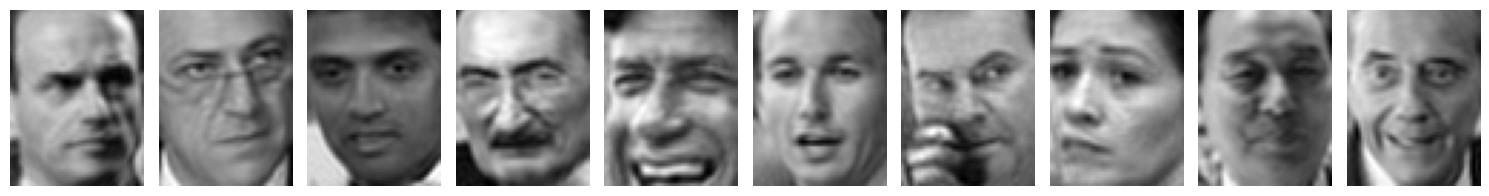

CLUSTER ID:6


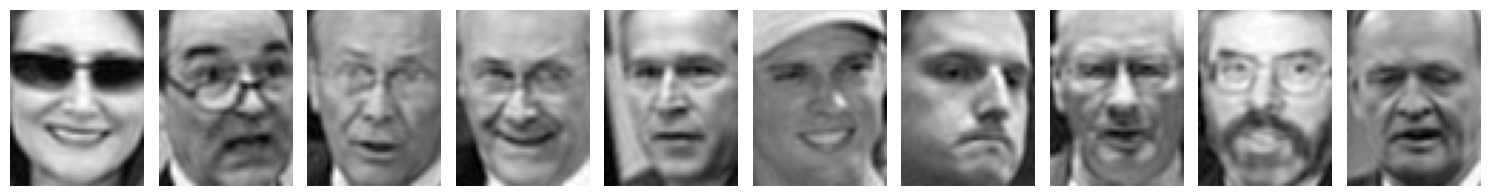

CLUSTER ID:7


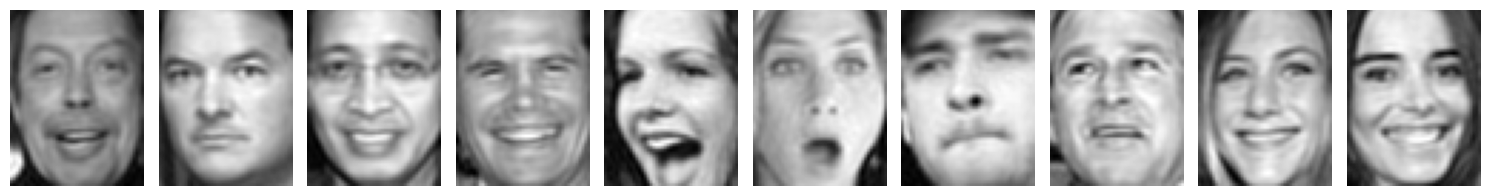

CLUSTER ID:8


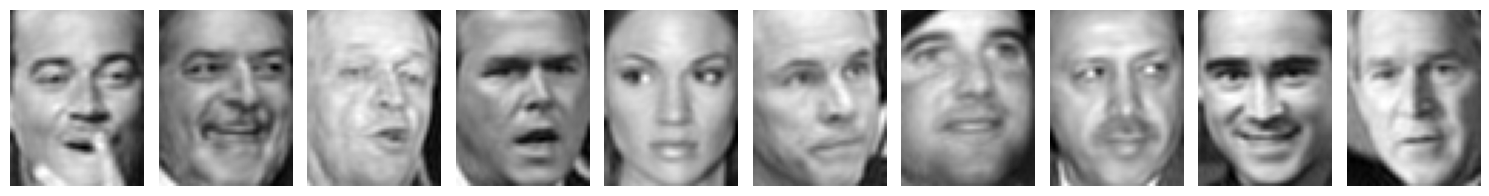

CLUSTER ID:9


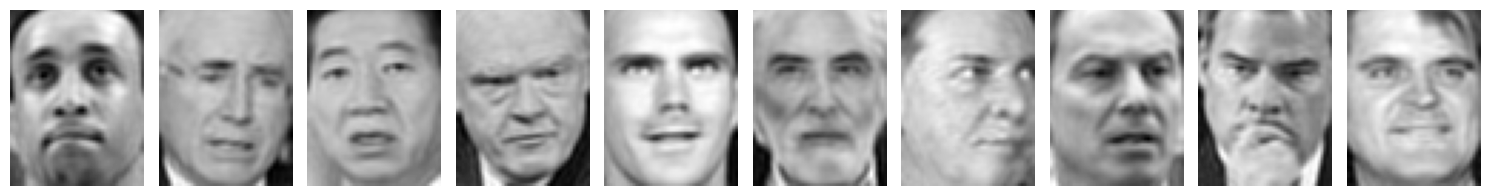

CLUSTER ID:10


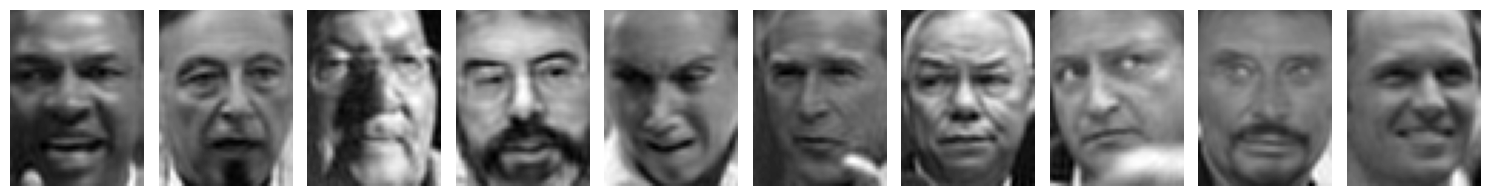

CLUSTER ID:11


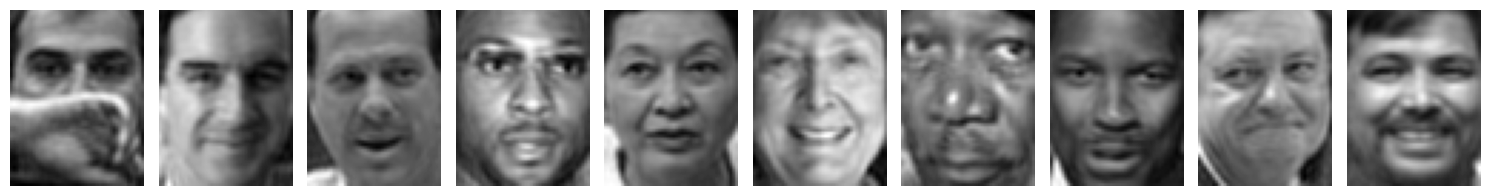

In [47]:
n_clusters=12

kmeans_red = KMeans(n_clusters=n_clusters, random_state=42).fit(X_pca)
inertias = {i: np.sum((X_pca[kmeans_red.labels_ == i] - kmeans_red.cluster_centers_[i])**2) for i in range(n_clusters)}
print("Sorted per-cluster inertia:", dict(sorted(inertias.items(), key=lambda x: x[1])))

for i in range(n_clusters):
    print(f"CLUSTER ID:{i}")
    X_cluster = pca.inverse_transform(X_pca[kmeans_red.labels_ == i])
    image_group_viewer(X_cluster[:10], size=(62, 47), cntperrow=10)

Based on visual inspection, clusters 3, 7, and 9 contain faces that appear similar. For each cluster, Let's fit a GMM with four candidate numbers of Gaussian components and evaluate which configuration produces higher-quality generated images.

Similar Images Group : 3 | Count of Samples: 917
Number of Components:25 for Image Group: 3


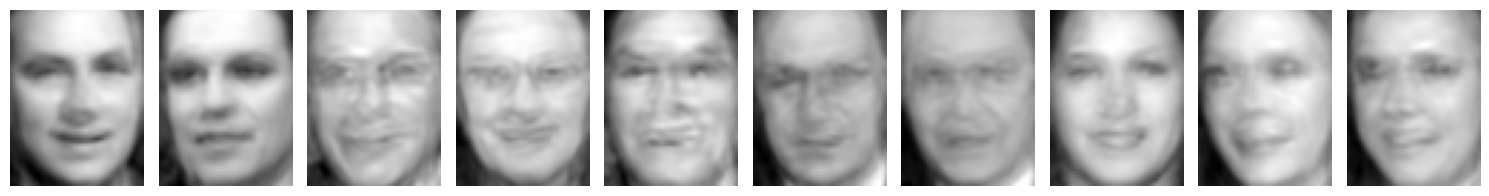

Number of Components:50 for Image Group: 3


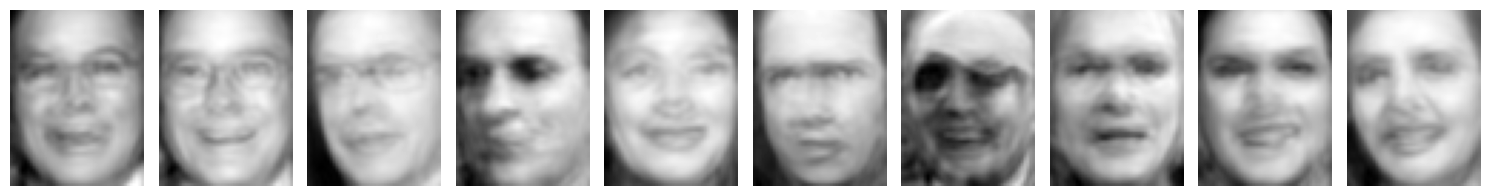

Number of Components:75 for Image Group: 3


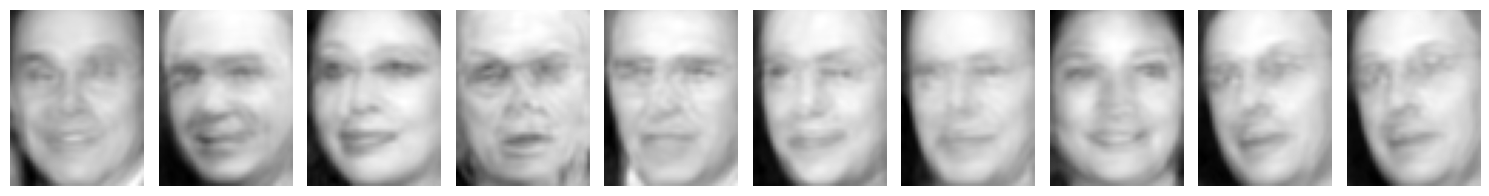

Number of Components:100 for Image Group: 3


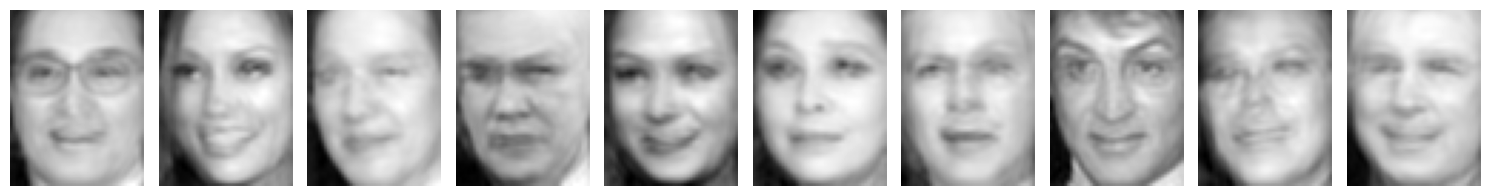

--------------------------------------------------
Similar Images Group : 7 | Count of Samples: 1351
Number of Components:25 for Image Group: 7


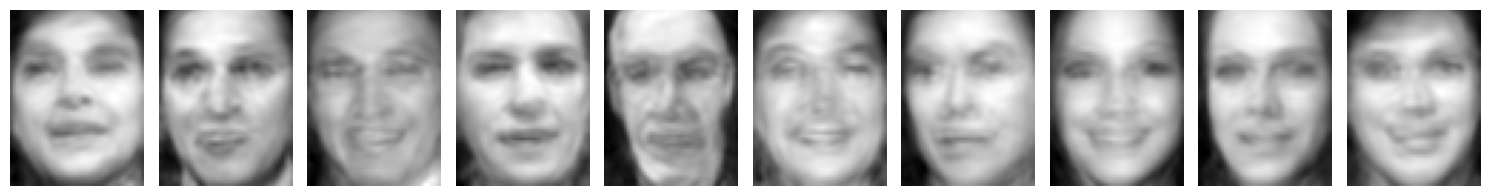

Number of Components:50 for Image Group: 7


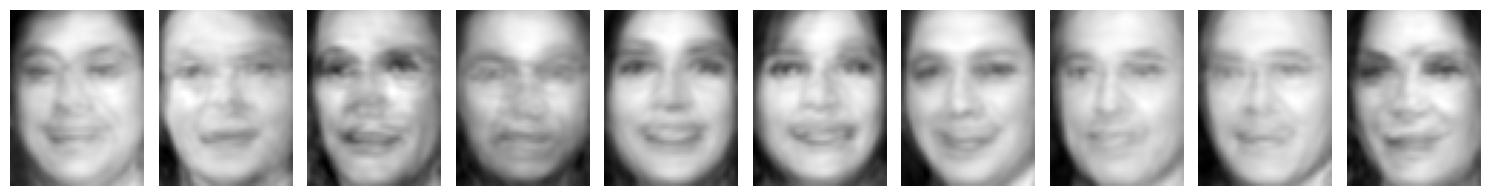

Number of Components:75 for Image Group: 7


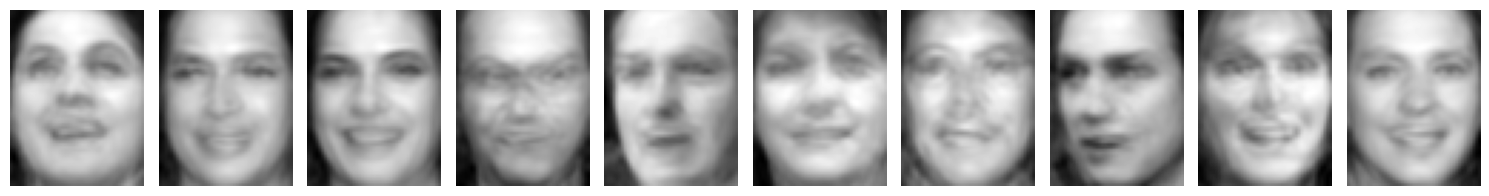

Number of Components:100 for Image Group: 7


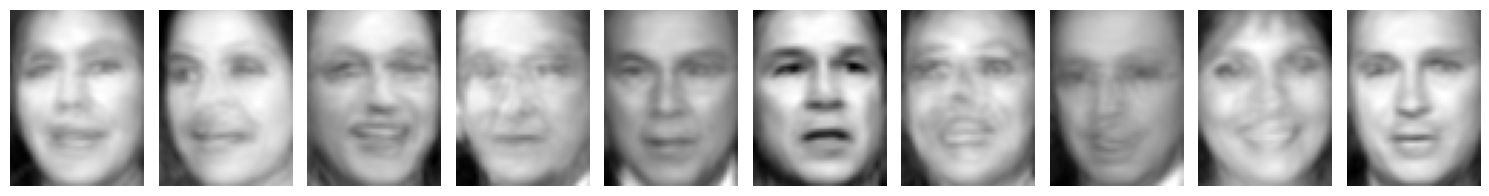

--------------------------------------------------
Similar Images Group : 9 | Count of Samples: 1143
Number of Components:25 for Image Group: 9


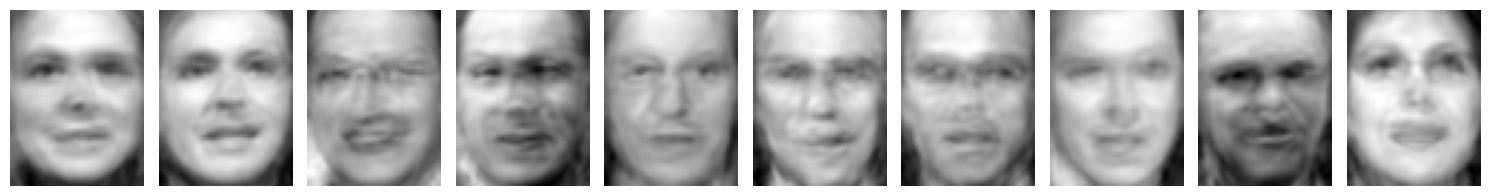

Number of Components:50 for Image Group: 9


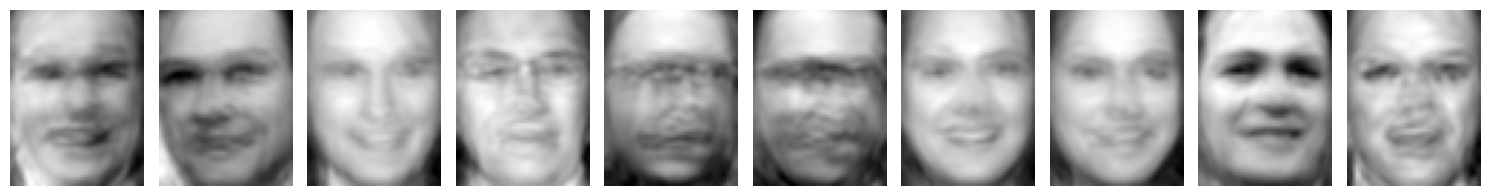

Number of Components:75 for Image Group: 9


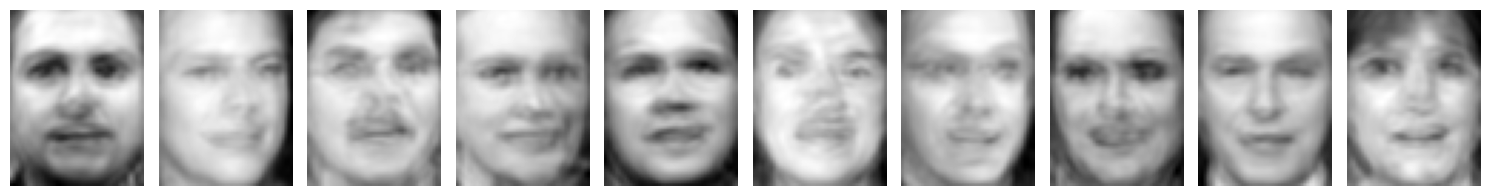

Number of Components:100 for Image Group: 9


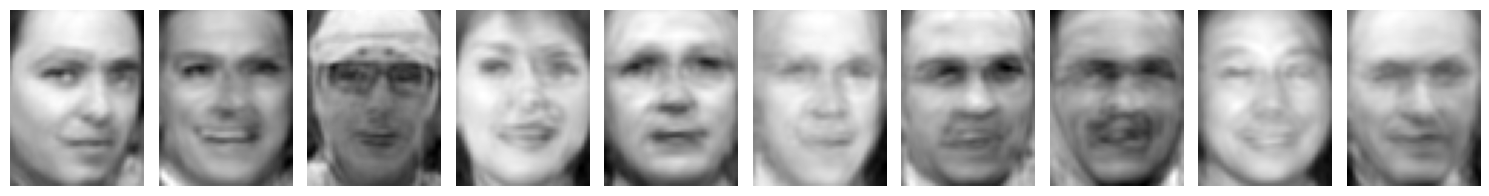

--------------------------------------------------
CPU times: total: 33min 4s
Wall time: 5min 42s


In [56]:
%%time

cluster_id_list = [3,7,9] 
for cluster_id in cluster_id_list:
    X_clsuter = X_pca[kmeans_red.labels_==cluster_id] # picking the subset
    print(f"Similar Images Group : {cluster_id} | Count of Samples: {len(X_clsuter)}")
    components_list = [25,50,75,100]
    for n_components in components_list:
        gmm = BayesianGaussianMixture(n_components=n_components,random_state=42,n_init=5 ,covariance_type="full").fit(X_clsuter)
        print(f"Number of Components:{n_components} for Image Group: {cluster_id}")
        X_gen,_ = gmm.sample(10)
        X_gen = pca.inverse_transform(X_gen)
        image_group_viewer(X_gen,size=(62,47), cntperrow=10)
    print("-"*50)

**Results and Insights**

We did it! Check out the first row of generated faces: the model generated human-like faces that don’t directly copy any training images. Our goal was to generalize the model using fewer Gaussian components, aiming to create recognizable faces with minimal clusters while avoiding exact duplicates from the dataset. This worked as expected—fitting a GMM on a smaller, similar subset of faces allowed it to capture that group’s patterns effectively. While overfitting to the subset is a risk, in the context of image generation, a bit of overfitting can actually help produce more convincing faces.

For the similar face group from Cluster 3 with 25 Gaussians, we see a mix of human-like faces, some noise, and occasional blended features. This reflects the GMM’s attempt to model the cohesive patterns of that specific face group.

---
**Conclusion**
- **GMM Limitations**: GMMs may not be ideal for image generation, as images often don’t align with the *mixture of Gaussians* assumption underlying the model.
- **Impact of Components**: Increasing the `n_components` hyperparameter adds more parameters, causing the model to learn finer details from the training set. This results in generated faces that resemble the source data too closely at high component counts.
- **LFW Challenges**: The LFW dataset’s variability—different lighting, exposures, backgrounds, and features like mustaches—complicates the identification of “similar images” for both GMMs and K-Means clustering.
- **Value of the Approach**: Despite these challenges, using statistical modeling like GMMs to synthesize faces is a compelling concept. It lays a foundation for understanding modern, state-of-the-art image generation techniques that build on similar probabilistic ideas.

For more machine learning projects and insights, let’s connect:

- **LinkedIn:** <a href="https://linkedin.com/in/hooman-amini-ha3">linkedin.com/in/hooman-amini-ha3</a>

- **GitHub:** <a href="https://github.com/hoom4n">github.com/hoom4n<a>